# NACD Dataset
- semi-synthetic
- synthetic censoring
- real

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(2021)

import sys
sys.path.append('../src')
from models import DNMC, NMC, NSurv, MLP, train_model, evaluate_model

# Load NACD dataset

- categorical variables have already been cell coded
- however, numeric variables have not been standardized

In [51]:
df = pd.read_csv('http://pssp.srv.ualberta.ca/system/predictors/datasets/000/000/032/original/All_Data_updated_may2011_CLEANED.csv?1350302245')

numrc_cols = df.nunique() > 2
df.loc[:, numrc_cols] = (df.loc[:, numrc_cols] - df.loc[:, numrc_cols].mean()) / df.loc[:, numrc_cols].std()

In [52]:
df['CENSORED'].value_counts()

0    1523
1     879
Name: CENSORED, dtype: int64

In [3]:
OUTCOMES = ['SURVIVAL', 'CENSORED']
X = df.drop(OUTCOMES, axis=1).sample(frac=1, random_state=2021)
X = X.values

In [4]:
print('There are', X.shape[1], 'features')

There are 51 features


In [5]:
df['SURVIVAL']

0      -0.988528
1       1.059539
2       0.384151
3      -0.941069
4      -0.267267
          ...   
2397   -0.586857
2398   -0.879964
2399    0.588593
2400    0.537483
2401   -0.906387
Name: SURVIVAL, Length: 2402, dtype: float64

## Semi-Synthetic Dataset

- real X
- synthetic failure times
- synthetic failure probabilities
- synthetic censoring times

For all models, we need:
- performance measures
- identification of factors
  - for ours, this is coefficients of first layer of Omega, Psi, Phi
  - for the other models, this is coeffiecients of first layer of whatever is available

We will need at least 10 repeated runs to ensure we are doing this well.

In [31]:
from generate_data import generate_semi_synthetic, generate_synth_censoring, onehot

In [7]:
N_BINS = 10
synth = generate_semi_synthetic(X, 10, 10, N_BINS, 1999)

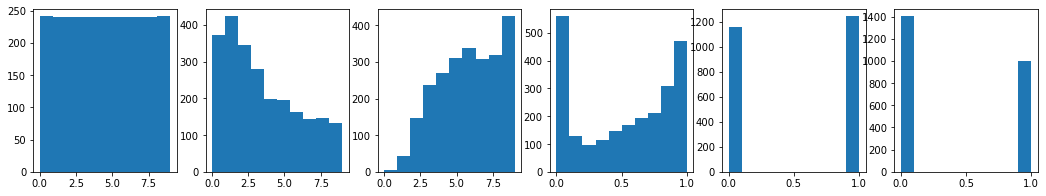

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(18, 3))

ax[0].hist(synth['y_disc'])
ax[1].hist(synth['t_disc'])
ax[2].hist(synth['c_disc'])
ax[3].hist(synth['e_prob'])
ax[4].hist(synth['e'])
ax[5].hist(synth['s'])

plt.show()

In [9]:
synth['shared_features'], synth['tc_features'], synth['e_features']

(array([ 5, 34,  6, 24, 50, 39, 35,  2, 20, 37]),
 array([33, 29, 15, 30, 22, 42, 28, 48, 17, 41]),
 array([45,  9,  1,  7, 10,  8, 32, 26, 31, 21]))

In [10]:
x_train, x_val, x_test = X[:1500], X[1500:1900], X[1900:]

y = onehot(synth['y_disc'], ncategories=10)
y_train, y_val, y_test = y[:1500], y[1500:1900], y[1900:]

s_train, s_val, s_test = synth['s'][:1500], synth['s'][1500:1900], synth['s'][1900:]
e_train, e_val, e_test = synth['e'][:1500], synth['e'][1500:1900], synth['e'][1900:]

In [ ]:
model = DNMC(n_bins=N_BINS, lr=.03, ld=10.)
        
train_model(
    model, (x_train, y_train, s_train), (x_val, y_val, s_val),
    300, learning_rate=1e-3)

## Create model to visualize results

In [28]:
nacd_e_pred, t_pred, c_pred = model.forward_pass(x_test)
nacd_s_test = s_test
nacd_e_test = e_test

## SUPPORT

In [34]:
FILL_VALUES = {
    'alb': 3.5,
    'pafi': 333.3,
    'bili': 1.01,
    'crea': 1.01,
    'bun': 6.51,
    'wblc': 9.,
    'urine': 2502.
}

TO_DROP = ['aps', 'sps', 'surv2m', 'surv6m', 'prg2m', 'prg6m', 'dnr', 'dnrday']
TO_DROP = TO_DROP + ['sfdm2', 'hospdead']

# load, drop columns, fill using specified fill values
df = pd.read_csv('../datasets/support2.csv').drop(TO_DROP,axis=1).fillna(value=FILL_VALUES)

# get dummies for categorical vars
df = pd.get_dummies(df, dummy_na=True)

# fill remaining values to the median

df = df.fillna(df.median())

# standardize numeric columns

numrc_cols = df.dtypes == 'float64'
df.loc[:, numrc_cols] = (df.loc[:, numrc_cols] - df.loc[:, numrc_cols].mean()) / df.loc[:, numrc_cols].std()

OUTCOMES = ['death', 'd.time']
X = df.drop(OUTCOMES, axis=1).sample(frac=1, random_state=2021)
X = X.values

synth = generate_synth_censoring(
    X, df['d.time'].values, df['death'].values,
    10, N_BINS, 1999,
    e_prob_spread=2.)

x_train, x_val, x_test = X[:6000], X[6000:7500], X[7500:]

y = onehot(synth['y_disc'], ncategories=10)
y_train, y_val, y_test = y[:6000], y[6000:7500], y[7500:]

s_train, s_val, s_test = synth['s'][:6000], synth['s'][6000:7500], synth['s'][7500:]
e_train, e_val, e_test = synth['e'][:6000], synth['e'][6000:7500], synth['e'][7500:]

In [35]:
model = DNMC(n_bins=N_BINS, lr=.03, ld=10.)
        
train_model(
    model, (x_train, y_train, s_train), (x_val, y_val, s_val),
    300, learning_rate=1e-3)

Epoch 15 | Train Loss: 2.7736 | Train NLL: 2.7308 | Val Loss: 2.7858 | Val NLL: 2.74410



In [36]:
support_e_pred, t_pred, c_pred = model.forward_pass(x_test)
support_s_test = s_test
support_e_test = e_test

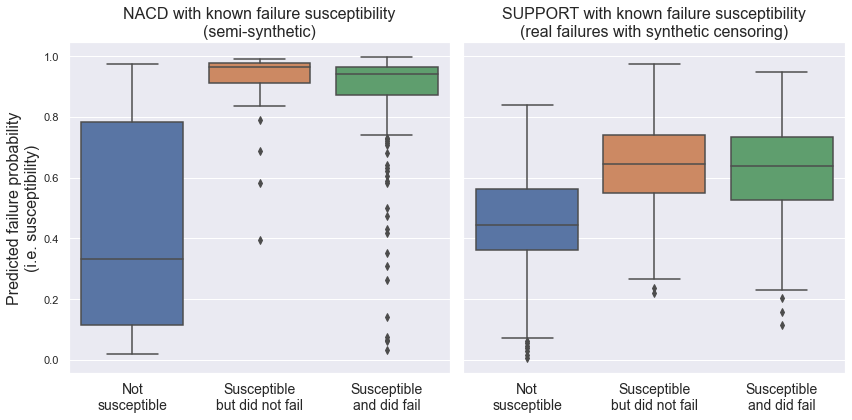

In [49]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.set()

sns.boxplot(ax=ax[0], y=nacd_e_pred.numpy(), x=nacd_s_test+nacd_e_test)
ax[0].set_xticklabels(
    ['Not\nsusceptible', 'Susceptible\nbut did not fail', 'Susceptible\nand did fail'], fontsize=14)
ax[0].set_ylabel('Predicted failure probability\n(i.e. susceptibility)', fontsize=16)
ax[0].set_title('NACD with known failure susceptibility\n(semi-synthetic)', fontsize=16)

sns.boxplot(ax=ax[1], y=support_e_pred.numpy(), x=support_s_test+support_e_test)
ax[1].set_xticklabels(
    ['Not\nsusceptible', 'Susceptible\nbut did not fail', 'Susceptible\nand did fail'], fontsize=14)
#ax[1].set_ylabel('Predicted failure probability\n(i.e. susceptibility)', fontsize=16)
ax[1].set_title('SUPPORT with known failure susceptibility\n(real failures with synthetic censoring)', fontsize=16)

plt.tight_layout()
plt.savefig('../results/e_pred_by_group.pdf')
plt.show()

## Explore hyperparams *on validation set*

In [21]:
### BEGIN COLLECTING RESULTS HERE ###
all_results = []
all_weight_results = []

pstrue = s_train.mean()
importance_weights = [1 / (1 - pstrue), 1 / pstrue]

LEARNING_RATE = 6e-4
N_BINS = 10
MAX_EPOCHS = 500

In [23]:
# NOTE that we are skipping importance weights here.

for random_state in [2020, 2016, 2013]:
    
    print('')
    print('STARTING RUNS WITH RANDOM STATE', random_state)
    print('')

    synth = generate_semi_synthetic(X, 10, 10, N_BINS, random_state)
    
    x_train, x_val, x_test = X[:1500], X[1500:1900], X[1900:]

    y = onehot(synth['y_disc'], ncategories=10)
    y_train, y_val, y_test = y[:1500], y[1500:1900], y[1900:]

    s_train, s_val, s_test = synth['s'][:1500], synth['s'][1500:1900], synth['s'][1900:]
    e_train, e_val, e_test = synth['e'][:1500], synth['e'][1500:1900], synth['e'][1900:]
    
    for lr in np.logspace(-2, -1, 6):
        
        # Run NMC
        
        print('Running NMC with lr =', lr)
        
        model = NMC(n_bins=N_BINS, lr=lr)
        
        train_model(
            model, (x_train, y_train, s_train), (x_val, y_val, s_val),
            MAX_EPOCHS, learning_rate=LEARNING_RATE)
        
        all_results.append(
            evaluate_model(
                model, (x_val, y_val, s_val), e_val,
                (synth['shared_features'], synth['tc_features'], synth['e_features']),
                dataset='nacd', random_state=random_state))
        
        # Run NSurv
        
        print('Running NSurv with lr =', lr)
        
        model = NSurv(n_bins=N_BINS, lr=lr)
        
        train_model(
            model, (x_train, y_train, s_train), (x_val, y_val, s_val),
            MAX_EPOCHS, learning_rate=LEARNING_RATE)
        
        all_results.append(
            evaluate_model(
                model, (x_val, y_val, s_val), e_val,
                (synth['shared_features'], synth['tc_features'], synth['e_features']),
                dataset='nacd', random_state=random_state))
        
        # Run MLP
        
        print('Running MLP with lr =', lr)
        
        model = MLP(lr=lr)
        
        train_model(
            model, (x_train, y_train, s_train), (x_val, y_val, s_val),
            MAX_EPOCHS, learning_rate=LEARNING_RATE)
        
        all_results.append(
            evaluate_model(
                model, (x_val, y_val, s_val), e_val,
                (synth['shared_features'], synth['tc_features'], synth['e_features']),
                dataset='nacd', random_state=random_state))
        
        # Run DNMC
        
        for ld in np.logspace(-2, 2, 10):
            
            print('Running DNMC with lr =', lr, 'and ld =', ld)
            
            model = DNMC(n_bins=N_BINS, lr=lr, ld=ld)
        
            train_model(
                model, (x_train, y_train, s_train), (x_val, y_val, s_val),
                MAX_EPOCHS, learning_rate=LEARNING_RATE)

            all_results.append(
                evaluate_model(
                    model, (x_val, y_val, s_val), e_val,
                    (synth['shared_features'], synth['tc_features'], synth['e_features']),
                    dataset='nacd', random_state=random_state))


STARTING RUNS WITH RANDOM STATE 2020

Running NMC with lr = 0.01


KeyboardInterrupt: 

In [ ]:
results_frame = pd.DataFrame(all_results)
results_frame.to_csv('/Users/mme4/Dropbox/s/mme4/Dropbox/nacd_val_results.csv')

In [19]:
results_frame = pd.DataFrame(all_results)
results_frame.groupby(['model', 'ld']).mean()

random_state        lr  avg_test_loss  avg_test_nll     e_auc  \
model ld                                                                      
DNMC  0.0001        4000.0  0.029157       1.816388      1.324318  0.877805   
      0.0010        4000.0  0.029157       1.822333      1.324929  0.876351   
      0.0100        4000.0  0.029157       1.795925      1.306051  0.875950   
      0.1000        4000.0  0.029157       1.825953      1.328983  0.878733   
      1.0000        4000.0  0.029157       1.913302      1.320609  0.876722   
MLP   0.0010        4000.0  0.029157       0.534942      0.431841  0.804002   
NMC   0.0010        4000.0  0.029157       1.722271      1.265744  0.870734   
NSurv 0.0010        4000.0  0.029157       1.713312      1.260565  0.854716   

                  y_ci  N_shared  N_distinct    phi_in   phi_out  omega_in  \
model ld                                                                     
DNMC  0.0001  0.856872      10.0        10.0  0.061758  0.062962  0.137730   
      0.0010  0.857698      10.0        10.0  0.064734  0.067115  0.135137   
      0.0100  0.858959      10.0        10.0  0.063454  0.067078  0.141942   
      0.1000  0.856556      10.0        10.0  0.064810  0.069998  0.140319   
      1.0000  0.858637      10.0        10.0  0.067586  0.069901  0.136043   
MLP   0.0010       NaN      10.0        10.0  0.096324  0.079222       NaN   
NMC   0.0010  0.858108      10.0        10.0  0.090523  0.083474  0.119578   
NSurv 0.0010  0.844916      10.0        10.0       NaN       NaN  0.133198   

              omega_out    psi_in   psi_out  
model ld                                     
DNMC  0.0001   0.098622  0.158081  0.109456  
      0.0010   0.097530  0.161613  0.108588  
      0.0100   0.098641  0.159159  0.107932  
      0.1000   0.102371  0.154285  0.109360  
      1.0000   0.100760  0.162660  0.106642  
MLP   0.0010        NaN       NaN       NaN  
NMC   0.0010   0.076423       NaN       NaN  
NSurv 0.0010   0.108797       NaN       NaN

## Now, fix hyperparameters and evaluate on *test set*

In [11]:
### TESTING HERE ###
model = DNMC(
    n_bins=N_BINS,
    importance_weights=importance_weights,
    ld=1e-2, lr=1e-2, l_mtlr=0)

train_model(
    model, (x_train, y_train, s_train), (x_val, y_val, s_val),
    100, learning_rate=LEARNING_RATE)

all_results.append(
    evaluate_model(
        model, (x_test, y_test, s_test), e_test,
        (synth['shared_features'], synth['tc_features'], synth['e_features']),
        dataset='nacd', random_state=4000))

In [14]:
model = NMC(
    n_bins=N_BINS,
    importance_weights=importance_weights,
    lr=1e-2)

train_model(
    model, (x_train, y_train, s_train), (x_val, y_val, s_val),
    100, learning_rate=LEARNING_RATE)

all_results.append(
    evaluate_model(
        model, (x_test, y_test, s_test), e_test,
        (synth['shared_features'], synth['tc_features'], synth['e_features']),
        dataset='nacd', random_state=4000))

Epoch  0 | Train Loss: 14.4019 | Train NLL: 5.3152 | Val Loss: 12.9250 | Val NLL: 4.9831
Epoch  1 | Train Loss: 11.5838 | Train NLL: 4.5523 | Val Loss: 10.7116 | Val NLL: 4.5617
Epoch  2 | Train Loss: 9.5810 | Train NLL: 4.0984 | Val Loss: 9.0896 | Val NLL: 4.2454
Epoch  3 | Train Loss: 8.0971 | Train NLL: 3.7308 | Val Loss: 7.8985 | Val NLL: 3.9887
Epoch  4 | Train Loss: 6.9954 | Train NLL: 3.4285 | Val Loss: 7.0085 | Val NLL: 3.7698
Epoch  5 | Train Loss: 6.1722 | Train NLL: 3.1824 | Val Loss: 6.3352 | Val NLL: 3.5848
Epoch  6 | Train Loss: 5.5479 | Train NLL: 2.9806 | Val Loss: 5.8197 | Val NLL: 3.4296
Epoch  7 | Train Loss: 5.0627 | Train NLL: 2.8095 | Val Loss: 5.4131 | Val NLL: 3.2933
Epoch  8 | Train Loss: 4.6815 | Train NLL: 2.6654 | Val Loss: 5.0884 | Val NLL: 3.1745
Epoch  9 | Train Loss: 4.3732 | Train NLL: 2.5392 | Val Loss: 4.8257 | Val NLL: 3.0709
Epoch 10 | Train Loss: 4.1210 | Train NLL: 2.4285 | Val Loss: 4.6098 | Val NLL: 2.9799
Epoch 11 | Train Loss: 3.9115 | Train N

In [15]:
model = NSurv(
    n_bins=N_BINS,
    importance_weights=importance_weights,
    lr=1e-2)

train_model(
    model, (x_train, y_train, s_train), (x_val, y_val, s_val),
    100, learning_rate=LEARNING_RATE)

all_results.append(
    evaluate_model(
        model, (x_test, y_test, s_test), e_test,
        (synth['shared_features'], synth['tc_features'], synth['e_features']),
        dataset='nacd', random_state=4000))

Epoch  0 | Train Loss: 11.6363 | Train NLL: 5.3989 | Val Loss: 10.6245 | Val NLL: 5.0098
Epoch  1 | Train Loss: 9.6653 | Train NLL: 4.5684 | Val Loss: 9.1519 | Val NLL: 4.5628
Epoch  2 | Train Loss: 8.2789 | Train NLL: 4.0836 | Val Loss: 8.0088 | Val NLL: 4.1953
Epoch  3 | Train Loss: 7.2439 | Train NLL: 3.7270 | Val Loss: 7.1640 | Val NLL: 3.9352
Epoch  4 | Train Loss: 6.4622 | Train NLL: 3.4597 | Val Loss: 6.5254 | Val NLL: 3.7430
Epoch  5 | Train Loss: 5.8585 | Train NLL: 3.2503 | Val Loss: 6.0298 | Val NLL: 3.5914
Epoch  6 | Train Loss: 5.3782 | Train NLL: 3.0749 | Val Loss: 5.6312 | Val NLL: 3.4602
Epoch  7 | Train Loss: 4.9871 | Train NLL: 2.9217 | Val Loss: 5.3084 | Val NLL: 3.3470
Epoch  8 | Train Loss: 4.6647 | Train NLL: 2.7865 | Val Loss: 5.0406 | Val NLL: 3.2447
Epoch  9 | Train Loss: 4.3959 | Train NLL: 2.6661 | Val Loss: 4.8153 | Val NLL: 3.1513
Epoch 10 | Train Loss: 4.1691 | Train NLL: 2.5581 | Val Loss: 4.6270 | Val NLL: 3.0693
Epoch 11 | Train Loss: 3.9761 | Train NLL

In [17]:
pd.DataFrame(all_results).T

,0,1,2
dataset,nacd,nacd,nacd
random_state,4000,4000,4000
model,DNMC,NMC,NSurv
ld,0.01,0.001,0.001
lr,0.01,0.01,0.01
avg_test_loss,NaN,3.189805,3.28494
avg_test_nll,2.354549,2.193762,2.265486
e_auc,0.863972,0.859859,0.801239
y_ci,0.844141,0.851342,0.8457
N_shared,10,10,10


## Synthetic Failure Susceptibility

- real X
- real censoring and failure times
- synthetic failure susceptibility, with failure time changed to censoring time

For all models, we need:
- performance measures
- identification of factors
  - for ours, this is coefficients of first layer of Omega, Psi, Phi
  - for the other models, this is coeffiecients of first layer of whatever is available

As before, we will need at least 10 repeated runs to ensure we are doing this well

## Real Data

- real X, real censoring times, real failure times

For all models, we need performance measures.

For ours, we also want to see:
- boxplots of failure susceptibility among those who did vs didn't have the event
- list of top K factors for failure susceptibility, failure time, censoring time